# Antecedentes

Imports variables globales y clases auxiliares.

## Imports

Bibliotecas a utilizar

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

import sklearn
from sklearn.svm import SVR, OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

## Auxiliares

Se definen clases y funciones auxiliares que nos van a servir más adelante.

In [ ]:
# clase que nos dice si hay elementos afuera del dominio de aplicación usando
# el método de leverage
class LeverageMethod(sklearn.base.BaseEstimator):
    def fit(self, x, y=None):
        self.normal_mat = np.linalg.inv(x.T @ x)
        self.n_samples = x.shape[0]
        self.n_features = x.shape[1]
        return self

    def decision_function(self, x):
        leverages = np.diagonal(x @ self.normal_mat @ x.T)
        leverages = self.threshold_ - leverages
        return leverages

    def predict(self, x):
        leverages = self.decision_function(x)
        preds = np.where(leverages < 0, -1, 1)
        return preds

    @property
    def threshold_(self):
        return 3*self.n_features/self.n_samples

In [ ]:
# función que regresa el nombre de un stimador de sklearn
# model: el modelo a extraer el nombre
# returns: el nombre del modelo
def mname(model):
    return model.__class__.__name__

In [ ]:
# función que regresa el validation score
# model: el modelo de sklearn a evaluar
# x: datos de entrada
# y: salida esperada
# metrics: la metrica (o metricas en una lista) para evaluar
def score_cv(model, x, y, metrics="r2"):
    res = sklearn.model_selection.cross_validate(
        pipeline, x_train, y, scoring=metrics, cv=CV_SPLITTER, n_jobs=-1
    )
    
    if isinstance(metrics, str):
        return np.mean(res["test_score"])
    return {metric: np.mean(res[f"test_{metric}"]) for metric in metrics}

## Globales

Variables globales a usar

In [ ]:
# semilla para cosas random
RANDOM_STATE = 5712492
# minima varianza a conservar en las features
MIN_VARIANCE = 0

# agoritmo de escalamiento
# (StandardScaler, MinMaxScaler o Normalizer)
SCALER = StandardScaler()

# primer selector/transformador de features
# (SelectFromModel o SelectKBest)
feat_selector_model = RandomForestRegressor(n_estimators=250, #650 es bueníimo
                                             #criterion='squared_error', #criterion{“squared_error”, “absolute_error”, “poisson”}, default=”squared_error”
                                             max_depth=50, 
                                             #min_samples_split=9, #default=2
                                             min_samples_leaf=8, 
                                             #min_weight_fraction_leaf=0.4, 
                                             #max_features=100, 
                                             #max_leaf_nodes=1000, 
                                             min_impurity_decrease=1E-6, 
                                             #bootstrap=False, 
                                             #oob_score=False, 
                                             #n_jobs=None, 
                                             random_state=RANDOM_STATE, 
                                             #verbose=0, 
                                             warm_start=True, 
                                             #ccp_alpha=0.0, 
                                             #max_samples=None
                                            )
FEAT_SELECTOR1 = SelectFromModel(feat_selector_model, max_features=70)

# segundo selector/transformador de features
# (Genetic o PCA)
n_feats_desired = 16
FEAT_SELECTOR2 = PCA(n_components=n_feats_desired, random_state=RANDOM_STATE)

# algoritmo de regresión final
REGRESSOR = SVR(cache_size=1000, max_iter=100000, C=2.0)
 
# algoritmos de dominio de aplicación
APP_DOMAINS = [
    LeverageMethod(),
    OneClassSVM(nu=0.01, gamma=0.1)
]

# metricas a usar como evaluación
METRICS = ["r2", "neg_mean_squared_error"]

# splitter de cross validation
CV_SPLITTER = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# numero de y scrambles
N_SCRAMBLES = 150

# Cargar datos

Descargar datos de la nube y leerlos en un DataFrame y `x, y`.

In [ ]:
# descargamos data
! gdown --id 1Pl90HjkxdulEKhlYdLNWsOxN1BKKJTyv ##add the corresponding pad for the file 'nlz_data.csv' 
! gdown --id 1gi1zAHjlEziF3C21Tq8fCTFpZdcST34s ##add the corresponding pad for the file 'nlz_activity.csv' 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Pl90HjkxdulEKhlYdLNWsOxN1BKKJTyv
To: /content/nlz_activity.csv
100% 964/964 [00:00<00:00, 1.16MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1gi1zAHjlEziF3C21Tq8fCTFpZdcST34s
To: /content/nlz_data.csv
100% 2.01M/2.01M [00:00<00:00, 69.5MB/s]


In [ ]:
# cargamos data
df_x = pd.read_csv("nlz_data.csv")
df_x = df_x.iloc[:, 1:]  # quitar "No."
df_x = df_x.select_dtypes("number")  # quitar non_numeric
df_y = pd.read_csv("nlz_activity.csv")

df_data = df_x.assign(Activity=df_y)
df_data

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02,Activity
0,426.89,8.712041,32.9867,50.1089,33.7899,55.0964,0.673198,1.022631,0.689590,1.124416,...,1.000000,1.0,0.8,0.5,1.0,1,0.900000,0.166667,1.000,5.316053
1,456.92,8.621132,35.2283,54.3198,36.0058,59.7210,0.664685,1.024902,0.679355,1.126811,...,0.666667,1.0,0.8,0.5,1.0,1,0.852381,0.333333,1.000,6.148742
2,426.90,8.712245,32.7879,50.1016,33.5854,55.4684,0.669141,1.022482,0.685416,1.132008,...,0.833333,1.0,0.8,0.5,1.0,1,0.876190,0.166667,1.000,5.504456
3,456.93,8.621321,35.0295,54.3125,35.8013,60.0930,0.660934,1.024764,0.675496,1.133830,...,0.666667,1.0,0.8,0.5,1.0,1,0.852381,0.333333,1.000,6.167491
4,456.93,8.621321,35.0295,54.3125,35.8013,60.0930,0.660934,1.024764,0.675496,1.133830,...,0.666667,1.0,0.8,0.5,1.0,1,0.852381,0.333333,1.000,5.271646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,422.48,7.971321,34.4008,53.9961,35.1479,59.7770,0.649072,1.018794,0.663168,1.127868,...,0.833333,1.0,0.8,0.5,1.0,1,0.876190,0.333333,1.000,5.920819
70,461.33,9.414898,33.8142,50.4326,34.6478,55.0404,0.690086,1.029237,0.707098,1.123273,...,0.833333,1.0,0.8,0.5,1.0,1,0.876190,0.166667,0.875,5.301030
71,461.33,9.414898,33.8142,50.4326,34.6478,55.0404,0.690086,1.029237,0.707098,1.123273,...,0.833333,1.0,0.8,0.5,1.0,1,0.876190,0.166667,0.875,4.853872
72,496.01,8.131311,39.5885,61.8615,41.0798,68.8403,0.648992,1.014123,0.673439,1.128530,...,0.666667,1.0,0.8,0.5,1.0,1,0.852381,0.166667,0.750,4.756962


In [ ]:
# dividimos train test con stratified
discretizer = sklearn.preprocessing.KBinsDiscretizer(
  n_bins=10, encode="ordinal", strategy="uniform"
)
splitter = StratifiedShuffleSplit(test_size=0.25, random_state=RANDOM_STATE)
y_discrete = discretizer.fit_transform(df_y.values)
split, split_test = next(splitter.split(df_x.values, y_discrete))

fractions = ["train" if i in split else "test" for i in range(df_data.shape[0])]
df_data = df_data.assign(fraction=fractions)
df_data

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02,Activity,fraction
0,426.89,8.712041,32.9867,50.1089,33.7899,55.0964,0.673198,1.022631,0.689590,1.124416,...,1.0,0.8,0.5,1.0,1,0.900000,0.166667,1.000,5.316053,test
1,456.92,8.621132,35.2283,54.3198,36.0058,59.7210,0.664685,1.024902,0.679355,1.126811,...,1.0,0.8,0.5,1.0,1,0.852381,0.333333,1.000,6.148742,train
2,426.90,8.712245,32.7879,50.1016,33.5854,55.4684,0.669141,1.022482,0.685416,1.132008,...,1.0,0.8,0.5,1.0,1,0.876190,0.166667,1.000,5.504456,train
3,456.93,8.621321,35.0295,54.3125,35.8013,60.0930,0.660934,1.024764,0.675496,1.133830,...,1.0,0.8,0.5,1.0,1,0.852381,0.333333,1.000,6.167491,train
4,456.93,8.621321,35.0295,54.3125,35.8013,60.0930,0.660934,1.024764,0.675496,1.133830,...,1.0,0.8,0.5,1.0,1,0.852381,0.333333,1.000,5.271646,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,422.48,7.971321,34.4008,53.9961,35.1479,59.7770,0.649072,1.018794,0.663168,1.127868,...,1.0,0.8,0.5,1.0,1,0.876190,0.333333,1.000,5.920819,train
70,461.33,9.414898,33.8142,50.4326,34.6478,55.0404,0.690086,1.029237,0.707098,1.123273,...,1.0,0.8,0.5,1.0,1,0.876190,0.166667,0.875,5.301030,test
71,461.33,9.414898,33.8142,50.4326,34.6478,55.0404,0.690086,1.029237,0.707098,1.123273,...,1.0,0.8,0.5,1.0,1,0.876190,0.166667,0.875,4.853872,train
72,496.01,8.131311,39.5885,61.8615,41.0798,68.8403,0.648992,1.014123,0.673439,1.128530,...,1.0,0.8,0.5,1.0,1,0.852381,0.166667,0.750,4.756962,train


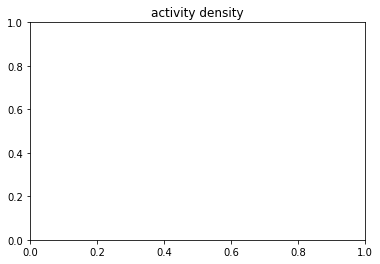

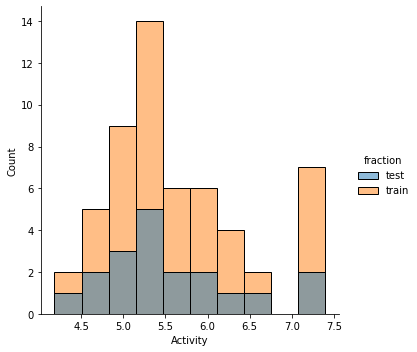

In [ ]:
# algunas cuantas visualizaciones

plt.title("activity density")
sns.displot(data=df_data, x="Activity", hue="fraction", alpha=0.5, bins=10)
plt.show()

In [ ]:
# sacamos los vectores (x, y) de interés
x_train = df_x[df_data["fraction"] == "train"].values
y_train = df_y[df_data["fraction"] == "train"].values
x_test = df_x[df_data["fraction"] == "test"].values
y_test = df_y[df_data["fraction"] == "test"].values
y_train = np.reshape(y_train, -1)
y_test = np.reshape(y_test, -1)

x_train = x_train.astype(float)
y_train = y_train.astype(float)
x_test = x_test.astype(float)
y_test = y_test.astype(float)

x_train

array([[4.56920000e+02, 8.62113208e+00, 3.52283000e+01, ...,
        8.52380952e-01, 3.33333333e-01, 1.00000000e+00],
       [4.26900000e+02, 8.71224490e+00, 3.27879000e+01, ...,
        8.76190476e-01, 1.66666667e-01, 1.00000000e+00],
       [4.56930000e+02, 8.62132075e+00, 3.50295000e+01, ...,
        8.52380952e-01, 3.33333333e-01, 1.00000000e+00],
       ...,
       [4.61330000e+02, 9.41489796e+00, 3.38142000e+01, ...,
        8.76190476e-01, 1.66666667e-01, 8.75000000e-01],
       [4.96010000e+02, 8.13131148e+00, 3.95885000e+01, ...,
        8.52380952e-01, 1.66666667e-01, 7.50000000e-01],
       [4.26890000e+02, 8.71204082e+00, 3.29867000e+01, ...,
        9.00000000e-01, 1.66666667e-01, 1.00000000e+00]])

# Entrenamiento

Se crea el modelo final final y se entrena

In [ ]:
# creamos pipeline: el modelo final final
steps = [
    ("var0", VarianceThreshold(MIN_VARIANCE)),
    ("scaling", SCALER),
    ("feat_selector1", FEAT_SELECTOR1),
    ("feat_selector2", FEAT_SELECTOR2),
    ("regressor", REGRESSOR)
]
pipeline = Pipeline(steps, verbose=True)
pipeline = pipeline.fit(x_train, y_train)
pipeline.set_params(verbose=False)
pipeline

[Pipeline] .............. (step 1 of 5) Processing var0, total=   0.0s
[Pipeline] ........... (step 2 of 5) Processing scaling, total=   0.0s
[Pipeline] .... (step 3 of 5) Processing feat_selector1, total=   2.1s
[Pipeline] .... (step 4 of 5) Processing feat_selector2, total=   0.0s
[Pipeline] ......... (step 5 of 5) Processing regressor, total=   0.0s


Pipeline(steps=[('var0', VarianceThreshold(threshold=0)),
                ('scaling', StandardScaler()),
                ('feat_selector1',
                 SelectFromModel(estimator=RandomForestRegressor(max_depth=50,
                                                                 min_impurity_decrease=1e-06,
                                                                 min_samples_leaf=8,
                                                                 n_estimators=250,
                                                                 random_state=5712492,
                                                                 warm_start=True),
                                 max_features=70)),
                ('feat_selector2', PCA(n_components=16, random_state=5712492)),
                ('regressor', SVR(C=2.0, cache_size=1000, max_iter=100000))])

# Validación

Se extraen los resultados y gráficas finales a reportar

## Resumen

In [ ]:
# Regresa un dataframe con datos generales de un entrenamiento completo
# metric: la metrica a usar para evaluar
def validate_summary(metric):
    scorer = sklearn.metrics.get_scorer(metric)
    df = pd.DataFrame(index=[metric], data={
        "train": scorer(pipeline, x_train, y_train),
        "test": scorer(pipeline, x_test, y_test),
        "cv": score_cv(pipeline, x_train, y_train, metrics=metric)
    })
    return df

In [ ]:
df = pd.DataFrame()
for metric in tqdm(METRICS, desc="Summary"):
    df_ = validate_summary(metric)
    df = df.append(df_)
df

Summary:   0%|          | 0/2 [00:00<?, ?it/s]

,train,test,cv
r2,0.941678,0.604659,0.606225
neg_mean_squared_error,-0.037407,-0.252753,-0.216385


## Dominio de aplicación

In [ ]:
# grafica residuales vs app_domain_score (leverage)
# model: el modelo de domionio de aplicación a usar (leverage o oneclassSVM)
# returns: el dataframe con los resultados
def validate_domain(model):
    transformer = pipeline[:-1]
    estimator = pipeline[-1]
    df = pd.DataFrame(columns=["Score", "Residual", "fraction"])
    
    splits = [(x_train, y_train, "train"), (x_test, y_test, "test")]
    for (x, y, fraction) in splits:
        z = transformer.transform(x)
        score = model.decision_function(z)
        res = estimator.predict(z) - y
        df_ = pd.DataFrame({"Score": score, "Residual": res,
                            "fraction": fraction})
        df = df.append(df_, ignore_index=True)
    
    sns.scatterplot(data=df, x="Score", y="Residual", hue="fraction")
    plt.title(f"Redisual vs {mname(model)}")
    plt.axvline(x=0, c="C2")
    plt.show()
    return df

In [ ]:
# primero entrena a los modelos de dominio de aplicación
transformer = pipeline[:-1]
for model in APP_DOMAINS:
    z_train = transformer.transform(x_train)
    model = model.fit(z_train)
print("Numero de features después de las reducciones:", z_train.shape[0])
APP_DOMAINS

Numero de features después de las reducciones: 55


[LeverageMethod(), OneClassSVM(gamma=0.1, nu=0.01)]

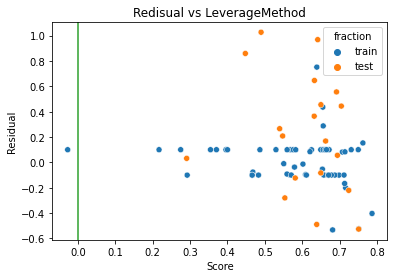

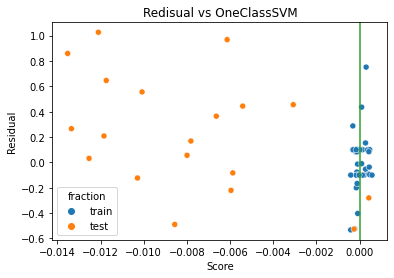

In [ ]:
for model in APP_DOMAINS:
    validate_domain(model)

## Y Scramble

In [ ]:
# hace un plot con los resultados del y scramble
# returns: el dataframe con la información
def validate_yscramble():
    df = pd.DataFrame()
    
    # data sin shuffle
    scores = score_cv(model, x_train, y_train, metrics=METRICS)
    info = {**scores, "scrambled": False, "number of iterations": 0}
    df = df.append(info, ignore_index=True)
    
    # data con shuffle
    for rep in trange(N_SCRAMBLES, desc="Scrambling"):
        y = sklearn.utils.shuffle(y_train)
        scores = score_cv(pipeline, x_train, y, metrics=METRICS)
        info = {**scores, "scrambled": True, "number of iterations": rep + 1}
        df = df.append(info, ignore_index=True)
        
    df = df.melt(id_vars=["number of iterations", "scrambled"], value_vars=METRICS,
                 var_name="metric", value_name="q2")
    
    # plot
    for metric in METRICS:
        df_ = df.loc[df["metric"] == metric]
        sns.scatterplot(data=df_, x="number of iterations", y="q2-cv", hue="scrambled")
        plt.title(f"Y-Scramble {metric}")
        plt.show()
    return df

Scrambling:   0%|          | 0/150 [00:00<?, ?it/s]

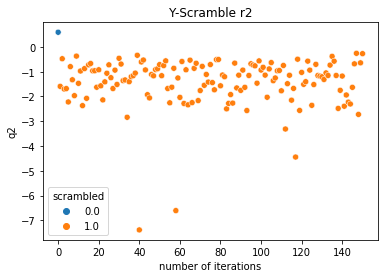

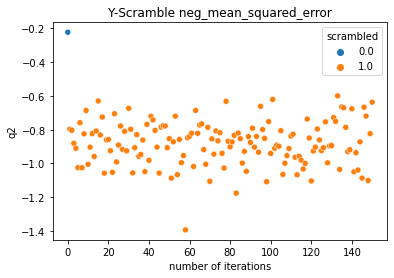

,number of iterations,scrambled,metric,q2
0,0.0,0.0,r2,0.591990
1,1.0,1.0,r2,-1.593609
2,2.0,1.0,r2,-0.477446
3,3.0,1.0,r2,-1.700915
4,4.0,1.0,r2,-1.683340
...,...,...,...,...
297,146.0,1.0,neg_mean_squared_error,-0.666882
298,147.0,1.0,neg_mean_squared_error,-0.719619
299,148.0,1.0,neg_mean_squared_error,-1.100973
300,149.0,1.0,neg_mean_squared_error,-0.823483


In [ ]:
validate_yscramble()

## True vs Pred

In [ ]:
def validate_true_vs_pred():
    df = pd.DataFrame(columns=["Experimental", "Predicted", "fraction"])
    splits = [(x_train, y_train, "train"), (x_test, y_test, "test")]
    for (x, y, fraction) in splits:
        yhat = pipeline.predict(x)
        df_ = pd.DataFrame({"Experimental": y, "Predicted": yhat, "fraction": fraction})
        df = df.append(df_, ignore_index=True)
    sns.scatterplot(data=df, x="Experimental", y="Predicted", hue="fraction")
    plt.title("Experimental vs Predicted")
    plt.plot()
    return df

,Experimental,Predicted,fraction
0,6.148742,6.900045,train
1,5.504456,5.404726,train
2,6.167491,5.764724,train
3,5.271646,5.371642,train
4,5.251037,5.404287,train
...,...,...,...
69,4.180259,5.206484,test
70,5.537602,5.745811,test
71,7.221849,6.695957,test
72,5.886057,5.942037,test


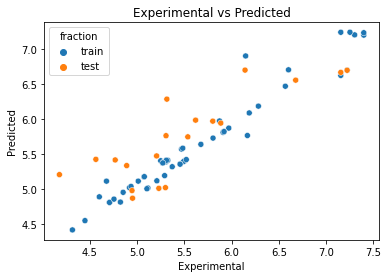

In [ ]:
validate_true_vs_pred()

# Test Final

Evaluación final con las nuevas mols

In [ ]:
# cargar datos
! gdown --id 1BzcBtnlyjE3BlDoHfFf7JBxreuB1tV8c #add the corresponding pad for the file 'explor5.csv' 
df_val = pd.read_csv("explor5.csv")
df_val

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1BzcBtnlyjE3BlDoHfFf7JBxreuB1tV8c
To: /content/explor5.csv
100% 1.03M/1.03M [00:00<00:00, 94.4MB/s]


,Cmpd,No.,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,...,CATS3D_10_LL,CATS3D_11_LL,CATS3D_12_LL,CATS3D_13_LL,CATS3D_14_LL,CATS3D_15_LL,CATS3D_16_LL,CATS3D_17_LL,CATS3D_18_LL,CATS3D_19_LL
0,2 Me pip R,91,3RO5,470.95,8.409821,36.7551,57.2034,37.7672,63.1362,0.656341,...,2,0,0,0,0,0,0,0,0,0
1,2 Me pip R (nlz),92,3RO5,440.92,8.479231,34.5135,52.9925,35.5513,58.5116,0.663721,...,2,0,0,0,0,0,0,0,0,0
2,2 Me pip S,93,3RO5,470.95,8.409821,36.7551,57.2034,37.7672,63.1362,0.656341,...,2,0,0,0,0,0,0,0,0,0
3,2 Me pip S (nlz),94,3RO5,440.92,8.479231,34.5135,52.9925,35.5513,58.5116,0.663721,...,2,0,0,0,0,0,0,0,0,0
4,compound 1,95,3RO5,468.93,8.683889,36.2283,55.3198,37.0058,60.7210,0.670894,...,2,0,0,0,0,0,0,0,0,0
5,compound 2,96,3RO5,468.93,8.683889,36.2283,55.3198,37.0058,60.7210,0.670894,...,2,0,0,0,0,0,0,0,0,0
6,compound 2 (nlz),97,3RO5,438.90,8.778000,33.9867,51.1089,34.7899,56.0964,0.679734,...,2,0,0,0,0,0,0,0,0,0
7,compound 3,98,3RO5,458.94,8.344364,35.7551,56.2034,36.7672,62.1362,0.650093,...,2,0,0,0,0,0,0,0,0,0
8,compound 3 (nlz),99,3RO5,428.91,8.410000,33.5135,51.9925,34.5513,57.5116,0.657127,...,2,0,0,0,0,0,0,0,0,0
9,compound 4,100,3RO5,430.88,8.793469,32.7015,50.4362,33.2444,55.3058,0.667378,...,2,0,0,0,0,0,0,0,0,0


In [ ]:
# seleccionar solo las columnas que estaban incluídas en el df inicial
names = df_val["Cmpd"]
df_val = df_val[df_x.columns]
df_val

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02
0,470.95,8.409821,36.7551,57.2034,37.7672,63.1362,0.656341,1.021489,0.674414,1.127432,...,1.00,0.666667,1,0.8,0.5,1,1,0.852381,0.166667,0.875
1,440.92,8.479231,34.5135,52.9925,35.5513,58.5116,0.663721,1.019087,0.683679,1.125223,...,1.00,1.000000,1,0.8,0.5,1,1,0.900000,0.166667,1.000
2,470.95,8.409821,36.7551,57.2034,37.7672,63.1362,0.656341,1.021489,0.674414,1.127432,...,1.00,0.666667,1,0.8,0.5,1,1,0.852381,0.166667,0.875
3,440.92,8.479231,34.5135,52.9925,35.5513,58.5116,0.663721,1.019087,0.683679,1.125223,...,1.00,1.000000,1,0.8,0.5,1,1,0.900000,0.166667,1.000
4,468.93,8.683889,36.2283,55.3198,37.0058,60.7210,0.670894,1.024441,0.685293,1.124463,...,1.00,0.666667,1,0.8,0.5,1,1,0.852381,0.166667,0.750
5,468.93,8.683889,36.2283,55.3198,37.0058,60.7210,0.670894,1.024441,0.685293,1.124463,...,1.00,0.666667,1,0.8,0.5,1,1,0.852381,0.166667,0.750
6,438.90,8.778000,33.9867,51.1089,34.7899,56.0964,0.679734,1.022178,0.695798,1.121928,...,1.00,1.000000,1,0.8,0.5,1,1,0.900000,0.166667,0.875
7,458.94,8.344364,35.7551,56.2034,36.7672,62.1362,0.650093,1.021880,0.668495,1.129749,...,1.00,0.666667,1,0.8,0.5,1,1,0.852381,0.333333,1.000
8,428.91,8.410000,33.5135,51.9925,34.5513,57.5116,0.657127,1.019461,0.677476,1.127678,...,1.00,1.000000,1,0.8,0.5,1,1,0.900000,0.166667,1.000
9,430.88,8.793469,32.7015,50.4362,33.2444,55.3058,0.667378,1.029310,0.678457,1.128690,...,1.00,0.833333,1,0.6,0.0,1,1,0.776190,0.333333,1.000


In [ ]:
# calcular todo
df = pd.DataFrame({"pred": pipeline.predict(df_val.values)}, index=names)
for model in APP_DOMAINS:
    score = model.decision_function(pipeline[:-1].transform(df_val.values))
    df[f"{mname(model)}_domain"] = score
df

,pred,LeverageMethod_domain,OneClassSVM_domain
Cmpd,,,
2 Me pip R,6.604635,0.582687,-0.008038
2 Me pip R (nlz),6.020723,0.649992,-0.009213
2 Me pip S,6.546250,0.555537,-0.007917
2 Me pip S (nlz),6.035479,0.649640,-0.009126
compound 1,5.878844,0.355521,-0.013733
compound 2,5.865445,0.323603,-0.013746
compound 2 (nlz),5.525532,0.321784,-0.013814
compound 3,6.038960,0.223152,-0.013317
compound 3 (nlz),5.828730,0.357607,-0.013410
